## M<sup>3</sup> Water Ice Detection Image Processing Pipeline

#### Importing Modules

In [2]:
import M3_Image_Class
import lab_spectra
from importlib import reload
reload(M3_Image_Class)
reload(lab_spectra)
from M3_Image_Class import M3_Stamp
from lab_spectra import get_spectrum
from get_USGS_H2OFrost import get_USGS_H2OFrost


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tifffile as tf
import rasterio as rio
import os
from os import path as path
import time

In [3]:
folder_path = 'D:/Data/Ice_Pipeline_Out_8-7-23'

with open(os.path.join(folder_path,'stampNames.txt')) as f:
    stamp_names = f.readlines()
stamp_names = [i[:-2] for i in stamp_names]

all_input_paths = [os.path.join(folder_path,'rfl_cropped',i) for i in os.listdir(os.path.join(folder_path,'rfl_cropped'))]
all_loc_paths = [os.path.join(folder_path,'loc_cropped',i) for i in os.listdir(os.path.join(folder_path,'loc_cropped'))]
all_obs_paths = [os.path.join(folder_path,'obs_cropped',i) for i in os.listdir(os.path.join(folder_path,'obs_cropped'))]

sample_in,sample_loc,sample_obs = all_input_paths[0],all_loc_paths[0],all_obs_paths[0]
analyzed_wavelengths = M3_Stamp(sample_in,sample_loc,sample_obs,stamp_names[0],folder_path).analyzed_wavelengths

### Image Processing Pipeline
<p>Each cell contains the importing of a module that contains the code to run a step. The user will be prompted to select an analysis folder to save the data to (and where necessary input folders already exist) and an input folder that contains the images the user wishes to process.</p>

In [20]:
##Running destriping step
from run_destriping_step import destripe
destripe(False) 

# User Inputs:
    # Path to Ice Pipeline Folder
    # Path to map to be used as the input into the spectral angle mapping step (i.e. rfl_smooth)

# Outputs:
    # ~rfl_destriped

Select Analysis Folder:
All images destriped in 23.51 minutes (100.00%)


In [ ]:
##Running shadow correction step
from run_correction_step import correction
correction(False)

# User Inputs:
    # Path to Ice Pipeline Folder
    # Path to map to be used as the input into the spectral angle mapping step (i.e. rfl_smooth)

# Outputs:
    # ~/rfl_correction

In [1]:
##Running spectrum smoothing step
from run_spectrum_smoothing_step import spectrum_smoothing
spectrum_smoothing(False)

# User Inputs:
    # Path to Ice Pipeline Folder
    # Path to map to be used as the input into the spectral angle mapping step (i.e. rfl_smooth)

# Outputs:
    # ~/rfl_smooth

Select Analysis Folder:
D:/Data/Ice_Pipeline_Out_8-7-23 selected for analysis
Select input folder for spectrum smoothing step:
The rfl_correction folder has been selected as the processing input
Applying spline along axis 2...


KeyboardInterrupt: 

In [ ]:
##Running band position mapping step
from run_band_position_mapping import band_position_mapping
band_position_mapping(False)

# User Inputs:
    # Path to Ice Pipeline Folder
    # Path to map to be used as the input into the spectral angle mapping step (i.e. rfl_smooth)

# Outputs:
    # ~/ice_band_location_summary.csv
    # ~/ice_band_locations
    # ~/ice_band_bool

In [4]:
##Getting usgs frost reference spectrum for spectral angle mapping
sample_in,sample_loc,sample_obs = (os.path.join(folder_path,i,os.listdir(os.path.join(folder_path,i))[0]) for i in ['rfl_smooth_complete','loc_cropped','obs_cropped'])
sample_in,sample_loc,sample_obs = [tf.imread(i) for i in [sample_in,sample_loc,sample_obs]]

with open(os.path.join(folder_path,'stampNames.txt')) as f:
    stamp_names = f.readlines()
stamp_names = [i[:-2] for i in stamp_names]

analyzed_wavelengths = M3_Stamp(sample_in,sample_loc,sample_obs,stamp_names[0],folder_path).analyzed_wavelengths

wvl,USGS_frost = get_USGS_H2OFrost('D:/Data/USGS_Water_Ice',analyzed_wavelengths)

In [ ]:
from run_spectral_angle_mapping import sa_mapping
sa_mapping(False,reference_spectrum=USGS_frost)

# User Inputs:
    # Path to Ice Pipeline Folder
    # Path to map to be used as the input into the spectral angle mapping step (i.e. rfl_smooth)
    # Threshold value (xx.x) to create boolean map of spectral angle detection criteria
    
# Outputs:
    # ~/spectral_angle_values
    # ~/spectral_angle_bool_xx.x

In [7]:
##Running euclidian distance mapping step
import run_euclidian_distance_mapping
reload(run_euclidian_distance_mapping)
from run_euclidian_distance_mapping import ed_mapping
ed_mapping(True,reference_spectrum=USGS_frost)

# User Inputs:
    # Path to Ice Pipeline Folder
    # Path to map to be used as the input into the spectral angle mapping step (i.e. rfl_smooth)
    # Threshold value (xx.x) to make the euclidian distance boolean map

# Outputs:
    # ~/euclidian_distance_values
    # ~/euclidian_distance_bool_xx.x

Select Analysis Folder:
D:/Data/Ice_Pipeline_Out_8-7-23 selected for analysis
Select input folder for spectral angle mapping step:
The rfl_smooth folder has been selected as the processing input
Analysis for 20090816t045833 complete (100.00%)
>>>Euclidian Distance Mapping complete for 0.0!


In [ ]:
##Running band depth mapping step
from run_band_depth_mapping import bd_mapping
bd_mapping(False)

# User Inputs:
    # Path to Ice Pipeline Folder
    # Path to map to be used as the input into the spectral angle mapping step (i.e. rfl_smooth)
    # Threshold (xx.x) used for making the band depth boolean maps

# Outputs:
    # ~/band_depth_values
    # ~/band_depth_bool_xx.x

In [25]:
def get_summary_dataframe(boolean_array:np.ndarray,map_coord_array:np.ndarray,value_name_list:list,*args)->pd.DataFrame:
    true_coords = np.where(boolean_array==True)
    value_array = np.array([i[true_coords] for i in args]).T #N by len(args) array of values at each True boolean pixel
    map_coords = map_coord_array[true_coords[0],true_coords[1],:]

    summary_array = np.concatenate([map_coords,np.array([true_coords[0],true_coords[1]]).T,value_array],axis=1)
    summary_df = pd.DataFrame(summary_array)
    summary_df.columns = ['Longitude','Latitude','Elevation','x','y',*value_name_list]

    return summary_df

In [54]:
##Getting ice water detection maps
criteria = {
    'Band Positioning':True,
    'Spectral Angle':20.0,
    'Band Depth':0.15
}

folder_path = 'D:/Data/Ice_Pipeline_Out_8-7-23'

with open(os.path.join(folder_path,'stampNames.txt')) as f:
    stamp_names = f.readlines()
stamp_names = [i[:-2] for i in stamp_names]

def get_bool_arrays(stamp_name,**kwargs)->tuple[np.ndarray,np.ndarray,np.ndarray]:
    if kwargs.get('Band Positioning')==True:
        array1 = tf.imread(os.path.join(folder_path,'ice_band_bool',f'{stamp_name}.tif'))
    else:
        array1 = np.ones(tf.imread(os.path.join(folder_path,'ice_band_bool',f'{stamp_name}.tif')).shape)
    
    if kwargs.get('Spectral Angle') != False:
        array2 = tf.imread(os.path.join(folder_path,f'spectral_angle_bool_{kwargs.get("Spectral Angle")}',f'{stamp_name}.tif'))
    else:
        array2 = np.ones(array1.shape)

    if kwargs.get('Band Depth') != False:
        array3 = tf.imread(os.path.join(folder_path,f'band_depth_bool_{kwargs.get("Band Depth")}',f'{stamp_name}.tif'))
    else:
        array3 = np.ones(array1.shape)

    return array1,array2,array3


array_list = [get_bool_arrays(i,**criteria) for i in stamp_names]

try:
    os.mkdir(os.path.join(folder_path,f'ice_detection_results_{criteria.get("Spectral Angle"):.0f}spa_{criteria.get("Band Depth"):.2f}bd'))
except:
    pass

new_bool_array = [i*j*k for i,j,k in array_list]
loc_arrays = [tf.imread(os.path.join(folder_path,'loc_cropped',i)) for i in os.listdir(os.path.join(folder_path,'loc_cropped'))]
sa_arrays = [tf.imread(os.path.join(folder_path,'spectral_angle_values_30.0',f'{i}.tif')) for i in stamp_names]
bd_arrays_3d = [tf.imread(os.path.join(folder_path,f'band_depth_values_0.10',f'{i}.tif')) for i in stamp_names]
bd1_arrays,bd2_arrays,bd3_arrays = [i[:,:,0] for i in bd_arrays_3d],[i[:,:,1] for i in bd_arrays_3d],[i[:,:,2] for i in bd_arrays_3d]

df_list = []
stamp_num = 1
for bool_array,loc_array,sa,bd1,bd2,bd3,stamp_name in zip(new_bool_array,loc_arrays,sa_arrays,bd1_arrays,bd2_arrays,bd3_arrays,stamp_names):
    tf.imwrite(os.path.join(folder_path,f'ice_detection_results_{criteria.get("Spectral Angle"):.0f}spa_{criteria.get("Band Depth"):.2f}bd',\
                            f'{stamp_name}.tif'),bool_array.astype('float32'))
    summary_df = get_summary_dataframe(bool_array,loc_array,['Spectral Angle','Band1 Depth','Band2 Depth','Band3 Depth'],sa,bd1,bd2,bd3)
    summary_df['Stamp_Num'] = stamp_num
    df_list.append(summary_df)
    stamp_num+=1

all_stamps_df = pd.concat(df_list,ignore_index=True)
all_stamps_df.to_csv(os.path.join(folder_path,f'ice_detection_location_summary_{criteria.get("Spectral Angle"):.0f}spa_{criteria.get("Band Depth"):.2f}bd.csv'))

In [5]:
##Loading RFL Images
rfl_im_list = [tf.imread(os.path.join(folder_path,'rfl_smooth_complete',i)) for i in os.listdir(os.path.join(folder_path,'rfl_smooth_complete'))]
rfl_rawim_list = [tf.imread(os.path.join(folder_path,'rfl_correction',i)) for i in os.listdir(os.path.join(folder_path,'rfl_correction'))]

3723.0 149.0 66


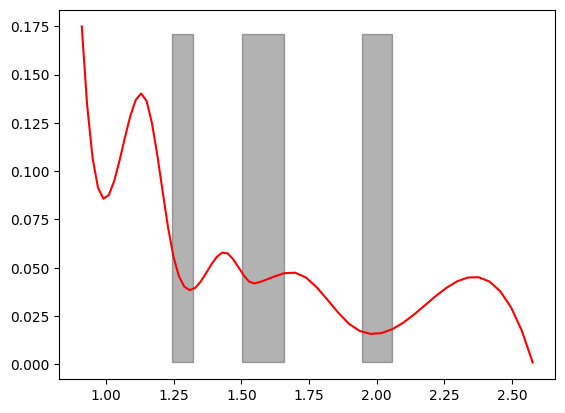

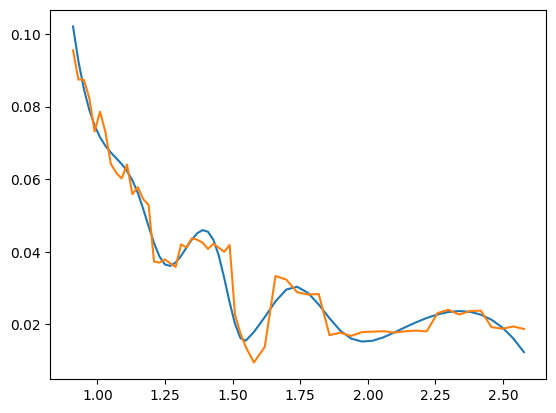

In [6]:
##Creating an averaged spectrum from summary results
summary_file_path = 'D:/Data/Ice_Pipeline_Out_8-7-23/ice_detection_location_summary_20spa_0.15bd.csv'
df = pd.read_csv(summary_file_path)

spec_array = np.zeros((0,len(analyzed_wavelengths)))
spec_array_raw = np.zeros((0,len(analyzed_wavelengths)))
plot_one = np.random.randint(0,df.index[-1])
prog = 0
for x,y,stamp_num in zip(df['x'],df['y'],df['Stamp_Num']):
    spec = rfl_im_list[stamp_num-1][int(x),int(y),:]
    spec_raw = rfl_rawim_list[stamp_num-1][int(x),int(y),:]
    if prog == plot_one:
        print (x,y,stamp_num)
        plt.plot(analyzed_wavelengths/1000,spec,color='red')
        for lo,hi in [(1.242,1.323),(1.503,1.659),(1.945,2.056)]:
            plt.fill_betweenx(np.arange(spec.min(),spec.max(),0.01),lo,hi,color='k',alpha=0.3)
    spec_array = np.concatenate([spec_array,spec[np.newaxis,:]])
    spec_array_raw = np.concatenate([spec_array_raw,spec_raw[np.newaxis,:]])
    prog+=1

fig = plt.figure()
plt.plot(analyzed_wavelengths/1000,np.mean(spec_array,axis=0),label='Cubic Spline Fit')
plt.plot(analyzed_wavelengths/1000,np.mean(spec_array_raw,axis=0),label='Raw')

#### Searching Lab Spectra for a reference spectrum for Spectral Angle Mapping

LMS-1 (41.2, 58.8) Unsorted Ice Day 2
LMS-1 (41.2, 58.8) Unsorted Ice Day 2


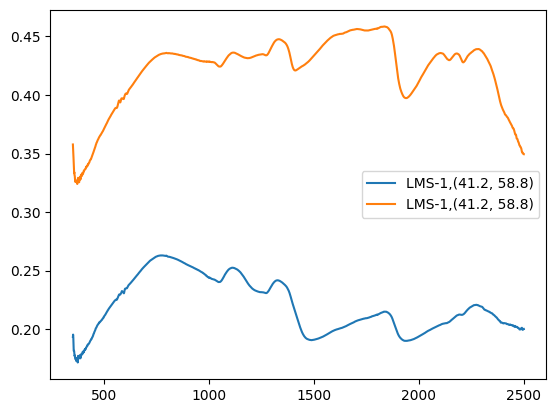

In [10]:
import lab_spectra
reload(lab_spectra)
from lab_spectra import get_spectrum

spectral_data_folder = 'C:/Users/zvig/OneDrive - University of Iowa/Desktop/Python Code/spectral_analysis/Spectral_Data'
data_acquisition_file = 'C:/Users/zvig/OneDrive - University of Iowa/Desktop/Python Code/spectral_analysis/Spectral Data Acquisition.xlsx'

search_criteria = {
    'Description':'LMS-1',
    'Ice Percentage':41.2,
    'Test Day':'Unsorted Ice Day 2',
    'Notes':'Ignore'
}

spectrum_list,wvl_list = get_spectrum(spectral_data_folder,data_acquisition_file,**search_criteria)

In [26]:
good_ind = np.where((wvl_list[0]>analyzed_wavelengths.min())&(wvl_list[0]<analyzed_wavelengths.max()))[0]
print (type(wvl_list))
print (np.array(wvl_list)[good_ind])


<class 'list'>


IndexError: index 561 is out of bounds for axis 0 with size 2